In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
from graspy.simulations import binary_sbm
from graspy.utils import symmetrize
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings("ignore")

$$(G_1, G_2) \sim \rho SBM(k,b,\Lambda)$$
$$b: V \to \{1,\dots,n\}, \Lambda \in \mathbb{R}^{kxk}$$
First, evaluate for ER random graphs:
$$|V_1|=|V_2|=100$$
$$k = 1, b = V \to 1$$
And sweep over values of $\Lambda$ from $[0] \to [1]$ and $\rho$ from $0$ to $1$

In [2]:
def rho_ER(rho,p,n=100):
    """
    Parameters
    ----------
    rho : float, int
        edge correlation between ER random graphs
    p : float, int
        probability of edge within graph
    n : int, optional
        number of vertices in graph
        
    Returns
    -------
    A : array-like
        The adjacency matrix of graph G1
    B : array-like
        The adjacency matrix of graph G2
    """
    nvec = [100]
    pvec = np.array([[p]])
    L = np.repeat(np.repeat(pvec,100,0),100,1)

    A = binary_sbm(nvec, pvec)
    B = np.random.binomial(1,(1-rho)*L + rho*A)
    np.fill_diagonal(B,0)
    
    return A,B

In [3]:
def double_plot(A, B):
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    sns.heatmap(A, ax=ax[0], xticklabels=False, yticklabels=False, cbar=False, cmap='Blues')
    sns.heatmap(B, ax=ax[1], xticklabels=False, yticklabels=False, cbar=False, cmap='Blues')
    ax[0].set_title('Adjacency matrix A', fontsize=20)
    ax[1].set_title('Adjacency matrix B',fontsize=20)
    plt.show()
    return

### Visualizing $A,B \sim \rho ER(p)$ with $\rho=0.9, p=0.8$

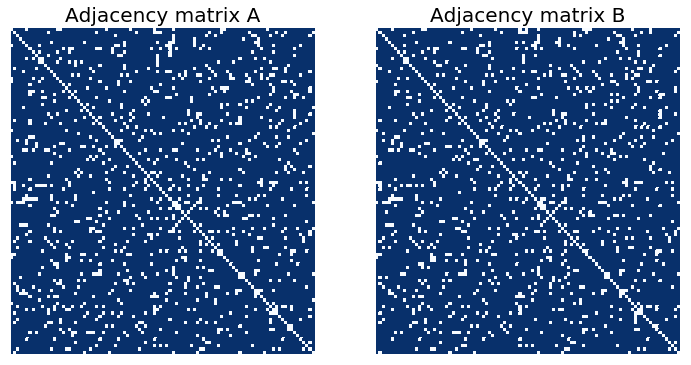

In [4]:
A,B = rho_ER(0.9,0.9)
double_plot(A,B)

In [5]:
def rho_h(nvec, pvec):
    mu = np.sum(np.multiply(nvec,pvec))/np.sum(nvec)
    var1 = np.square(np.subtract(pvec,mu))
    var = np.sum(np.multiply(nvec,var1))/np.sum(nvec)
    rhoh = np.nan_to_num(var/(mu*(1-mu)))
    return rhoh

def rho_t(nvec, pvec, rho):
    """
    Parameters
    ----------
    nvec : array-like(int)
        list of block sizes
    pvec : array-like(float)
        list of block probabilities
    rho : float
        edge correlation between two graphs
        
    Returns
    -------
    rhot : frac
        the total correlation between graphs
    """
    rhoh = rho_h(nvec,pvec)
    rhot = 1-(1-rho)*(1-rhoh)
    return rhot

def corr(A,B):
    A = A.ravel()
    B = B.ravel()
    x = np.vstack((A.ravel(),B.ravel()))
    return np.corrcoef(x)[0,1]

In [6]:
def plotly_plot(x,y,z):
    data = []
    for z_item in z:
        data.append(
            go.Surface(
                x=x,
                y=y,
                z=z_item,
                opacity=0.7)
        )

    layout = go.Layout(
        title='rho-ER',
        autosize=False,
        scene = dict(
            xaxis = dict(
                title='rho_e'),
            yaxis = dict(
                title='p'),
            zaxis = dict(
                title='hat(rho_t)') 
        ),
        width=750,
        height=750,
        margin=dict(
            l=65,
            r=50,
            b=65,
            t=90
        )
    )

    return go.Figure(data=data, layout=layout)

In [15]:
def gen_surface(func, rho_n=11, p_n=11):
    """
    Parameters
    ----------
    func : function
        should take adjacency matrices A and B and return a scalar value
    rho_n : int, optional, default = 11
        the number of values of rho between 0 and 1
    p_n : int, optional, default = 11
        the number of values of p between 0 and 1
    """
    z = z_err = np.zeros((rho_n,p_n))
    for i,rho in enumerate(np.linspace(0,1,rho_n)):
        for j,p in enumerate(np.linspace(0,1,p_n)):
            monte = []
            for _ in range(100):
                A,B = rho_ER(rho,p)
                monte.append(np.nan_to_num(corr(A,B)))
            z[i,j] = np.mean(monte)
            z_err[i,j] = np.std(monte)
    return z, z_err

In [16]:
def gen_ER_surf(rho_n=11,p_n=11):
    """
    Parameters
    ----------
    rho_n : int, optional, default = 11
        the number of values of rho between 0 and 1
    p_n : int, optional, default = 11
        the number of values of p between 0 and 1
    """
    x = np.linspace(0,1,p_n)
    y = np.linspace(0,1,rho_n)
    z = np.zeros((rho_n,p_n))
    z2 = np.zeros((rho_n,p_n))
    for i,p in enumerate(x):
        for j,rho in enumerate(y):
            monte = []
            monte2 = []
            for _ in range(10):
                A,B = rho_ER(rho,p)
                monte.append(corr(A,B))
                monte2.append(rho_t([100],[p],rho))
            z[i,j] = np.mean(monte)
            z2[i,j] = np.mean(monte2)
    fig = plotly_plot(x,y,[z,z2])
    return fig

In [17]:
fig = gen_ER_surf()
py.iplot(fig)